# Programming Assignment 3: Sentiment analysis

In this programming assignment, you will implement logistic regression to predict the sentiment of reviews that come from `imdb.com`, `amazon.com`, and `yelp.com`. Make sure the notebook is in the same folder that contains `full_set.txt`.

## 1. Load and preprocess data

In [5]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

The data set consists of 3000 sentences, each labeled '1' (if it came from a positive review) or '0' (if it came from a negative review). To be consistent with our notation from lecture, we will change the negative review label to '-1'.

In [6]:
## Read in the data set.
with open("full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

for i in range(5):
    print('Label: ',y[i],'; ', sentences[i])

Label:  -1 ;  So there is no way for me to plug it in here in the US unless I go by a converter.
Label:  1 ;  Good case, Excellent value.
Label:  1 ;  Great for the jawbone.
Label:  -1 ;  Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
Label:  1 ;  The mic is great.


### Preprocessing the text data

To transform this prediction problem into one amenable to linear classification, we will first need to preprocess the text data. We will do four transformations:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors, using a bag-of-words representation.

We begin with first two steps.

In [7]:
## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

### Stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such 'to' and 'from'. We have put together a very small list of stop words, but these are by no means comprehensive. Feel free to use something different; for instance, larger lists can easily be found on the web.

In [8]:
## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

What do the sentences look like so far?

In [9]:
sents_processed[0:10]

['so there is no way for me plug in here in us unless go by converter',
 'good case excellent value',
 'great for jawbone',
 'tied charger for conversations lasting more than minutes major problems',
 'mic is great',
 'have jiggle plug get line up right get decent volume',
 'if you have several dozen or several hundred contacts then imagine fun sending each them one by one',
 'if you are razr owner you must have this',
 'needless say wasted my money',
 'what waste money and time']

### Bag of words

In order to use linear classifiers on our data set, we need to transform our textual data into numeric data. The classical way to do this is known as the _bag of words_ representation. In this representation, each word is thought of as corresponding to a number in `{1, 2, ..., d}` where `d` is the size of our vocabulary. And each sentence is represented as a d-dimensional vector $x$, where $x_i$ is the number of times that word $i$ occurs in the sentence.

To do this transformation, we will make use of the `CountVectorizer` class in `scikit-learn` (Note that this is the only time you can call an external function from scikit-learn). We will cap the number of features at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in the corpus. This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.

**Task P1:** Once you get the bag-of-words representation, append a '1' to the beginning of each vector to allow our linear classifier to learn a bias term. What is the size of the resulting data_mat matrix?

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)
print ('The original size: ',data_features.shape)

The original size:  (3000, 4500)


In [11]:
## STUDENT: YOUR CODE STARTS HERE
# Task: Append '1' to the beginning of each vector.
# Hint: You can use data_features.toarray() to transform data_features into a numpy array
# The output should be a numpy array named data_mat


data_mat = data_features.toarray()
data_mat = np.insert(data_mat, 0, 1, axis=1)

## STUDENT: CODE ENDS
print ('The updated size: ',data_mat.shape)
data_mat

The updated size:  (3000, 4501)


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Training / test split

Finally, we split the data into a training set of 2500 sentences and a test set of 500 sentences (of which 250 are positive and 250 negative).

In [12]:
## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4501)
test data:  (500, 4501)


## 2. Fitting a logistic regression model to the training data

In this section, we will implement our own logistic regression solver using gradient descent. As we have seen in the class, to learn the parameters of logistic regression, we need to perform the following optimization:

$$
{\bf \tilde\theta} =
\underset{{\bf \theta}}{\operatorname{argmin}} \; L_\mathcal{D}({\bf \theta}) =
\underset{{\bf \theta}}{\operatorname{argmin}} \;\sum_{i=1}^{n} \ln \left( 1 + e^{y_i \; {\bf \theta}^T {\tilde x}_i} \right)
$$
where $y_i\in\{-1,+1\}$ is the label, ${\bf \tilde\theta}$ is the vector of coefficients:
$$
{\bf \tilde\theta} = \begin{bmatrix} \theta_0 & \theta_1 & ... & \theta_d \end{bmatrix}^T,
$$
and ${\tilde x}$ is the "augmented" feature vector (of $d+1$ dimensions), where we stick a 1 in the front of the original features:
$$
{\tilde x} = \begin{bmatrix} 1 & x_1 & ... & x_d \end{bmatrix}^T.
$$


There is no nice, closed-form solution like with [least-squares linear regression](http://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_pseudoinverse) so we will use [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) instead. Specifically we will use batch gradient descent which calculates the gradient from all data points in the data set. Luckily, the loss function $L_\mathcal{D}({\bf \tilde\theta})$ we want to minimize is [convex](http://en.wikipedia.org/wiki/Convex_optimization) so there is only one minimum. Thus the minimum we arrive at is the global minimum.

Gradient descent is a general method and requires twice differentiability for [smoothness](http://en.wikipedia.org/wiki/Smooth_function). It updates the parameters using a first-order approximation of the error surface.

$$
{\bf \tilde\theta}_{t+1} = {\bf \tilde\theta}_t + \nabla L_\mathcal{D}({\bf \tilde\theta}_t)
$$

**Task P2:** Derive the gradient of the loss $L_\mathcal{D}({\bf \tilde\theta})$ with respect to ${\bf \tilde\theta}$, namely $\nabla L_\mathcal{D}({\bf \tilde\theta}_t)$. The answer should depend on data points $(x_i,y_i)$ for $i=1,...,n$, and the model parameter ${\bf \tilde\theta}$. Make sure you get the sign correct. Also implement the function `weight_derivative`. Print the output of the code. 

In [481]:
from pdb import set_trace
def weight_derivative(weights, feature_matrix, labels):
    # Input:
    # weights: weight vector w, a numpy vector of dimension d
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d, each with value -1 or +1
    # Output:
    # Derivative of the regression cost function with respect to the weight w, a numpy array of dimension d
        
    ## STUDENT: Start of code ###
    
    # n (2500) rows, d (4501) columns

    count = 0
    y = labels
    theta = weights
    total = np.zeros(4501)
    #for each row (i in range(n)):
    for i in range(train_labels.size):
        x = feature_matrix[i,]
        # d is a single value, x and theta are length 4501
        d = np.dot(x, theta)
        power = -(y[i]*d) # power is what e is raised to, and is a single number
        exp = np.exp(power) #exp is a single number
        du = -(y[i] * x) #du is of length 4501 and is = -1 * label(-1 or 1) * x(weights)
        numerator = du * exp #du * e^u
        denom = 1 + exp # denom is a single number
        result = numerator / denom
        total = np.add(total, result)
        
    derivative = total
    return derivative
    # End of code ###

In [391]:
# STUDENT: PRINT THE OUTPUT AND COPY IT TO THE SOLUTION FILE
my_weights = np.zeros(data_mat.shape[1]) # a weight of all 1s
derivative = weight_derivative(my_weights,train_data,train_labels)

print (derivative[:10])

[ 0.  -0.5  0.5  0.5  0.  -1.   0.5  0.5  0.5 -0.5]


Now, we can just use the same gradient descent algorithm that we wrote in assignment 2 to solve it.

In [392]:
def gradient_descent(feature_matrix, labels, initial_weights, step_size, tolerance):
    # Gradient descent algorithm for logistic regression problem    
    
    # Input:
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d
    # initial_weights: initial weight vector to start with, a numpy vector of dimension d
    # step_size: step size of update
    # tolerance: tolerace epsilon for stopping condition
    # Output:
    # Weights obtained after convergence
    converged = False 
    weights = np.array(initial_weights) # current iterate
    i = 0
    while not converged:
        # impelementation of what the gradient descent algorithm does in every iteration
        # Refer back to the update rule listed above: update the weight
        i += 1
        derivative = weight_derivative(weights, feature_matrix, labels)
        
        weights -= (step_size * derivative)
        
        # Compute the gradient magnitude:
        
        gradient_magnitude = np.sqrt(np.sum(derivative**2))
        
        # Check the stopping condition to decide whether you want to stop the iterations
        # print ("grad mag :", gradient_magnitude)
        #print ("tolerance:", tolerance)
        
        if gradient_magnitude < tolerance:
            converged = True
        
        print ("Iteration: ",i,"gradient_magnitude: ", gradient_magnitude) # for us to check about convergence
        
    return(weights)

**Task P3:** Specify the initial_weights, step_size, and tolerance for the function `gradient_descent`. Copy the outputs of the code to the solution file.

In [412]:
#Initialize the weights, step size and tolerance
# Start of code
#STUDENT: Specify the initial_weights, step_size, and tolerance
initial_weights =  np.zeros(4501)

#e-5, 150
step_size = 2e-3
tolerance = 3
# end of code

# Use the regression_gradient_descent function to calculate the gradient decent and store it in the variable 'final_weights'
final_weights = gradient_descent(train_data,train_labels, initial_weights, step_size, tolerance)

# end of code
print ("Here are the final weights after convergence:")
print (final_weights)

Iteration:  1 gradient_magnitude:  209.21400526733385
Iteration:  2 gradient_magnitude:  178.58496774522143
Iteration:  3 gradient_magnitude:  159.8927105443988
Iteration:  4 gradient_magnitude:  146.5002270747251
Iteration:  5 gradient_magnitude:  135.9075180968014
Iteration:  6 gradient_magnitude:  127.0278241564014
Iteration:  7 gradient_magnitude:  119.3903556928941
Iteration:  8 gradient_magnitude:  112.78860450244265
Iteration:  9 gradient_magnitude:  107.07175483158811
Iteration:  10 gradient_magnitude:  102.14167671861115
Iteration:  11 gradient_magnitude:  97.88114002614333
Iteration:  12 gradient_magnitude:  94.1895353928877
Iteration:  13 gradient_magnitude:  90.96299842429494
Iteration:  14 gradient_magnitude:  88.11614643193525
Iteration:  15 gradient_magnitude:  85.57490653621652
Iteration:  16 gradient_magnitude:  83.28272066484196
Iteration:  17 gradient_magnitude:  81.19486432128949
Iteration:  18 gradient_magnitude:  79.2781651740734
Iteration:  19 gradient_magnitude:

Iteration:  153 gradient_magnitude:  29.51361579405536
Iteration:  154 gradient_magnitude:  29.411853083430547
Iteration:  155 gradient_magnitude:  29.310998713790713
Iteration:  156 gradient_magnitude:  29.211039022158626
Iteration:  157 gradient_magnitude:  29.111960634820235
Iteration:  158 gradient_magnitude:  29.01375045945506
Iteration:  159 gradient_magnitude:  28.916395677527568
Iteration:  160 gradient_magnitude:  28.819883736929285
Iteration:  161 gradient_magnitude:  28.724202344861887
Iteration:  162 gradient_magnitude:  28.629339460952075
Iteration:  163 gradient_magnitude:  28.53528329058921
Iteration:  164 gradient_magnitude:  28.44202227847729
Iteration:  165 gradient_magnitude:  28.3495451023931
Iteration:  166 gradient_magnitude:  28.257840667142826
Iteration:  167 gradient_magnitude:  28.166898098709613
Iteration:  168 gradient_magnitude:  28.07670673858503
Iteration:  169 gradient_magnitude:  27.98725613827762
Iteration:  170 gradient_magnitude:  27.89853605399196
I

Iteration:  302 gradient_magnitude:  20.180548613424772
Iteration:  303 gradient_magnitude:  20.141183980895804
Iteration:  304 gradient_magnitude:  20.102003671235074
Iteration:  305 gradient_magnitude:  20.063006252372052
Iteration:  306 gradient_magnitude:  20.024190307997838
Iteration:  307 gradient_magnitude:  19.985554437342206
Iteration:  308 gradient_magnitude:  19.94709725495456
Iteration:  309 gradient_magnitude:  19.90881739048862
Iteration:  310 gradient_magnitude:  19.870713488490814
Iteration:  311 gradient_magnitude:  19.832784208192326
Iteration:  312 gradient_magnitude:  19.79502822330462
Iteration:  313 gradient_magnitude:  19.757444221818506
Iteration:  314 gradient_magnitude:  19.720030905806567
Iteration:  315 gradient_magnitude:  19.68278699122896
Iteration:  316 gradient_magnitude:  19.645711207742433
Iteration:  317 gradient_magnitude:  19.608802298512618
Iteration:  318 gradient_magnitude:  19.572059020029382
Iteration:  319 gradient_magnitude:  19.535480141925

Iteration:  451 gradient_magnitude:  15.794456225601882
Iteration:  452 gradient_magnitude:  15.772358614481774
Iteration:  453 gradient_magnitude:  15.75033260407153
Iteration:  454 gradient_magnitude:  15.728377821781276
Iteration:  455 gradient_magnitude:  15.706493897769617
Iteration:  456 gradient_magnitude:  15.684680464916958
Iteration:  457 gradient_magnitude:  15.662937158799137
Iteration:  458 gradient_magnitude:  15.641263617661362
Iteration:  459 gradient_magnitude:  15.619659482392477
Iteration:  460 gradient_magnitude:  15.598124396499502
Iteration:  461 gradient_magnitude:  15.576658006082504
Iteration:  462 gradient_magnitude:  15.555259959809735
Iteration:  463 gradient_magnitude:  15.533929908893086
Iteration:  464 gradient_magnitude:  15.5126675070638
Iteration:  465 gradient_magnitude:  15.491472410548502
Iteration:  466 gradient_magnitude:  15.470344278045483
Iteration:  467 gradient_magnitude:  15.449282770701267
Iteration:  468 gradient_magnitude:  15.42828755208

Iteration:  598 gradient_magnitude:  13.161405728888061
Iteration:  599 gradient_magnitude:  13.146889715849989
Iteration:  600 gradient_magnitude:  13.132410406132202
Iteration:  601 gradient_magnitude:  13.117967653252938
Iteration:  602 gradient_magnitude:  13.103561311531813
Iteration:  603 gradient_magnitude:  13.089191236084107
Iteration:  604 gradient_magnitude:  13.074857282815074
Iteration:  605 gradient_magnitude:  13.060559308414323
Iteration:  606 gradient_magnitude:  13.046297170350243
Iteration:  607 gradient_magnitude:  13.032070726864463
Iteration:  608 gradient_magnitude:  13.017879836966394
Iteration:  609 gradient_magnitude:  13.003724360427787
Iteration:  610 gradient_magnitude:  12.989604157777364
Iteration:  611 gradient_magnitude:  12.975519090295476
Iteration:  612 gradient_magnitude:  12.961469020008835
Iteration:  613 gradient_magnitude:  12.947453809685257
Iteration:  614 gradient_magnitude:  12.933473322828494
Iteration:  615 gradient_magnitude:  12.91952742

Iteration:  745 gradient_magnitude:  11.357880217617382
Iteration:  746 gradient_magnitude:  11.34751831419268
Iteration:  747 gradient_magnitude:  11.337177943714682
Iteration:  748 gradient_magnitude:  11.326859035150552
Iteration:  749 gradient_magnitude:  11.316561517782786
Iteration:  750 gradient_magnitude:  11.306285321207445
Iteration:  751 gradient_magnitude:  11.296030375332384
Iteration:  752 gradient_magnitude:  11.285796610375499
Iteration:  753 gradient_magnitude:  11.275583956862997
Iteration:  754 gradient_magnitude:  11.265392345627646
Iteration:  755 gradient_magnitude:  11.255221707807083
Iteration:  756 gradient_magnitude:  11.24507197484209
Iteration:  757 gradient_magnitude:  11.234943078474918
Iteration:  758 gradient_magnitude:  11.224834950747594
Iteration:  759 gradient_magnitude:  11.214747524000249
Iteration:  760 gradient_magnitude:  11.204680730869471
Iteration:  761 gradient_magnitude:  11.194634504286661
Iteration:  762 gradient_magnitude:  11.1846087774

Iteration:  893 gradient_magnitude:  10.026158248568505
Iteration:  894 gradient_magnitude:  10.018349067155278
Iteration:  895 gradient_magnitude:  10.01055358656744
Iteration:  896 gradient_magnitude:  10.002771768120576
Iteration:  897 gradient_magnitude:  9.995003573277119
Iteration:  898 gradient_magnitude:  9.98724896364565
Iteration:  899 gradient_magnitude:  9.979507900980224
Iteration:  900 gradient_magnitude:  9.971780347179669
Iteration:  901 gradient_magnitude:  9.964066264286917
Iteration:  902 gradient_magnitude:  9.956365614488318
Iteration:  903 gradient_magnitude:  9.94867836011297
Iteration:  904 gradient_magnitude:  9.94100446363205
Iteration:  905 gradient_magnitude:  9.93334388765815
Iteration:  906 gradient_magnitude:  9.92569659494461
Iteration:  907 gradient_magnitude:  9.918062548384858
Iteration:  908 gradient_magnitude:  9.91044171101177
Iteration:  909 gradient_magnitude:  9.902834045997
Iteration:  910 gradient_magnitude:  9.89523951665035
Iteration:  911 g

Iteration:  1043 gradient_magnitude:  8.989176284208252
Iteration:  1044 gradient_magnitude:  8.983058871925016
Iteration:  1045 gradient_magnitude:  8.976950684148287
Iteration:  1046 gradient_magnitude:  8.970851698230055
Iteration:  1047 gradient_magnitude:  8.964761891598222
Iteration:  1048 gradient_magnitude:  8.958681241756304
Iteration:  1049 gradient_magnitude:  8.952609726283118
Iteration:  1050 gradient_magnitude:  8.946547322832473
Iteration:  1051 gradient_magnitude:  8.940494009132863
Iteration:  1052 gradient_magnitude:  8.93444976298717
Iteration:  1053 gradient_magnitude:  8.92841456227235
Iteration:  1054 gradient_magnitude:  8.922388384939136
Iteration:  1055 gradient_magnitude:  8.916371209011741
Iteration:  1056 gradient_magnitude:  8.910363012587554
Iteration:  1057 gradient_magnitude:  8.904363773836849
Iteration:  1058 gradient_magnitude:  8.898373471002472
Iteration:  1059 gradient_magnitude:  8.892392082399574
Iteration:  1060 gradient_magnitude:  8.8864195864

Iteration:  1190 gradient_magnitude:  8.17842694877227
Iteration:  1191 gradient_magnitude:  8.173456790822886
Iteration:  1192 gradient_magnitude:  8.168493205932531
Iteration:  1193 gradient_magnitude:  8.163536179927949
Iteration:  1194 gradient_magnitude:  8.158585698678731
Iteration:  1195 gradient_magnitude:  8.153641748097156
Iteration:  1196 gradient_magnitude:  8.14870431413803
Iteration:  1197 gradient_magnitude:  8.143773382798528
Iteration:  1198 gradient_magnitude:  8.13884894011805
Iteration:  1199 gradient_magnitude:  8.13393097217804
Iteration:  1200 gradient_magnitude:  8.12901946510186
Iteration:  1201 gradient_magnitude:  8.124114405054613
Iteration:  1202 gradient_magnitude:  8.119215778242998
Iteration:  1203 gradient_magnitude:  8.114323570915156
Iteration:  1204 gradient_magnitude:  8.10943776936052
Iteration:  1205 gradient_magnitude:  8.104558359909657
Iteration:  1206 gradient_magnitude:  8.099685328934116
Iteration:  1207 gradient_magnitude:  8.09481866284629

Iteration:  1338 gradient_magnitude:  7.507584677869862
Iteration:  1339 gradient_magnitude:  7.503453127542889
Iteration:  1340 gradient_magnitude:  7.4993264460565205
Iteration:  1341 gradient_magnitude:  7.4952046241554715
Iteration:  1342 gradient_magnitude:  7.491087652609713
Iteration:  1343 gradient_magnitude:  7.486975522214378
Iteration:  1344 gradient_magnitude:  7.482868223789685
Iteration:  1345 gradient_magnitude:  7.478765748180847
Iteration:  1346 gradient_magnitude:  7.474668086257983
Iteration:  1347 gradient_magnitude:  7.47057522891604
Iteration:  1348 gradient_magnitude:  7.466487167074701
Iteration:  1349 gradient_magnitude:  7.462403891678302
Iteration:  1350 gradient_magnitude:  7.458325393695751
Iteration:  1351 gradient_magnitude:  7.454251664120437
Iteration:  1352 gradient_magnitude:  7.450182693970157
Iteration:  1353 gradient_magnitude:  7.446118474287019
Iteration:  1354 gradient_magnitude:  7.44205899613737
Iteration:  1355 gradient_magnitude:  7.43800425

Iteration:  1486 gradient_magnitude:  6.944619550613274
Iteration:  1487 gradient_magnitude:  6.941119783573746
Iteration:  1488 gradient_magnitude:  6.93762375014704
Iteration:  1489 gradient_magnitude:  6.934131444026362
Iteration:  1490 gradient_magnitude:  6.93064285892036
Iteration:  1491 gradient_magnitude:  6.927157988553076
Iteration:  1492 gradient_magnitude:  6.923676826663893
Iteration:  1493 gradient_magnitude:  6.92019936700749
Iteration:  1494 gradient_magnitude:  6.9167256033537905
Iteration:  1495 gradient_magnitude:  6.913255529487916
Iteration:  1496 gradient_magnitude:  6.909789139210137
Iteration:  1497 gradient_magnitude:  6.906326426335822
Iteration:  1498 gradient_magnitude:  6.902867384695392
Iteration:  1499 gradient_magnitude:  6.899412008134274
Iteration:  1500 gradient_magnitude:  6.895960290512849
Iteration:  1501 gradient_magnitude:  6.892512225706408
Iteration:  1502 gradient_magnitude:  6.889067807605105
Iteration:  1503 gradient_magnitude:  6.8856270301

Iteration:  1634 gradient_magnitude:  6.464200749759659
Iteration:  1635 gradient_magnitude:  6.461192271446072
Iteration:  1636 gradient_magnitude:  6.458186738313313
Iteration:  1637 gradient_magnitude:  6.455184145887026
Iteration:  1638 gradient_magnitude:  6.452184489702645
Iteration:  1639 gradient_magnitude:  6.449187765305354
Iteration:  1640 gradient_magnitude:  6.446193968250076
Iteration:  1641 gradient_magnitude:  6.443203094101422
Iteration:  1642 gradient_magnitude:  6.440215138433682
Iteration:  1643 gradient_magnitude:  6.437230096830784
Iteration:  1644 gradient_magnitude:  6.4342479648862705
Iteration:  1645 gradient_magnitude:  6.431268738203272
Iteration:  1646 gradient_magnitude:  6.428292412394474
Iteration:  1647 gradient_magnitude:  6.425318983082094
Iteration:  1648 gradient_magnitude:  6.422348445897846
Iteration:  1649 gradient_magnitude:  6.419380796482922
Iteration:  1650 gradient_magnitude:  6.41641603048796
Iteration:  1651 gradient_magnitude:  6.41345414

Iteration:  1781 gradient_magnitude:  6.051406969072932
Iteration:  1782 gradient_magnitude:  6.048788004029274
Iteration:  1783 gradient_magnitude:  6.046171418177082
Iteration:  1784 gradient_magnitude:  6.043557208216872
Iteration:  1785 gradient_magnitude:  6.040945370855615
Iteration:  1786 gradient_magnitude:  6.038335902806725
Iteration:  1787 gradient_magnitude:  6.035728800790035
Iteration:  1788 gradient_magnitude:  6.033124061531787
Iteration:  1789 gradient_magnitude:  6.03052168176461
Iteration:  1790 gradient_magnitude:  6.027921658227505
Iteration:  1791 gradient_magnitude:  6.0253239876658276
Iteration:  1792 gradient_magnitude:  6.022728666831268
Iteration:  1793 gradient_magnitude:  6.020135692481842
Iteration:  1794 gradient_magnitude:  6.017545061381863
Iteration:  1795 gradient_magnitude:  6.014956770301936
Iteration:  1796 gradient_magnitude:  6.012370816018931
Iteration:  1797 gradient_magnitude:  6.009787195315976
Iteration:  1798 gradient_magnitude:  6.00720590

Iteration:  1929 gradient_magnitude:  5.688049299508653
Iteration:  1930 gradient_magnitude:  5.685749678162229
Iteration:  1931 gradient_magnitude:  5.683452009752374
Iteration:  1932 gradient_magnitude:  5.681156291773737
Iteration:  1933 gradient_magnitude:  5.678862521725401
Iteration:  1934 gradient_magnitude:  5.676570697110857
Iteration:  1935 gradient_magnitude:  5.674280815438001
Iteration:  1936 gradient_magnitude:  5.671992874219122
Iteration:  1937 gradient_magnitude:  5.669706870970893
Iteration:  1938 gradient_magnitude:  5.667422803214358
Iteration:  1939 gradient_magnitude:  5.6651406684749235
Iteration:  1940 gradient_magnitude:  5.662860464282343
Iteration:  1941 gradient_magnitude:  5.660582188170715
Iteration:  1942 gradient_magnitude:  5.6583058376784665
Iteration:  1943 gradient_magnitude:  5.656031410348346
Iteration:  1944 gradient_magnitude:  5.653758903727407
Iteration:  1945 gradient_magnitude:  5.651488315367009
Iteration:  1946 gradient_magnitude:  5.649219

Iteration:  2077 gradient_magnitude:  5.367702501391792
Iteration:  2078 gradient_magnitude:  5.365666816562256
Iteration:  2079 gradient_magnitude:  5.363632756953006
Iteration:  2080 gradient_magnitude:  5.3616003206133405
Iteration:  2081 gradient_magnitude:  5.359569505595712
Iteration:  2082 gradient_magnitude:  5.357540309955729
Iteration:  2083 gradient_magnitude:  5.355512731752137
Iteration:  2084 gradient_magnitude:  5.353486769046821
Iteration:  2085 gradient_magnitude:  5.351462419904797
Iteration:  2086 gradient_magnitude:  5.349439682394201
Iteration:  2087 gradient_magnitude:  5.347418554586287
Iteration:  2088 gradient_magnitude:  5.345399034555421
Iteration:  2089 gradient_magnitude:  5.343381120379068
Iteration:  2090 gradient_magnitude:  5.341364810137792
Iteration:  2091 gradient_magnitude:  5.339350101915246
Iteration:  2092 gradient_magnitude:  5.337336993798166
Iteration:  2093 gradient_magnitude:  5.335325483876367
Iteration:  2094 gradient_magnitude:  5.3333155

Iteration:  2225 gradient_magnitude:  5.083124667334557
Iteration:  2226 gradient_magnitude:  5.081309846214386
Iteration:  2227 gradient_magnitude:  5.079496392695378
Iteration:  2228 gradient_magnitude:  5.077684305229319
Iteration:  2229 gradient_magnitude:  5.075873582270323
Iteration:  2230 gradient_magnitude:  5.074064222274834
Iteration:  2231 gradient_magnitude:  5.072256223701619
Iteration:  2232 gradient_magnitude:  5.070449585011764
Iteration:  2233 gradient_magnitude:  5.068644304668669
Iteration:  2234 gradient_magnitude:  5.06684038113804
Iteration:  2235 gradient_magnitude:  5.065037812887895
Iteration:  2236 gradient_magnitude:  5.063236598388547
Iteration:  2237 gradient_magnitude:  5.061436736112607
Iteration:  2238 gradient_magnitude:  5.059638224534979
Iteration:  2239 gradient_magnitude:  5.057841062132851
Iteration:  2240 gradient_magnitude:  5.056045247385699
Iteration:  2241 gradient_magnitude:  5.054250778775272
Iteration:  2242 gradient_magnitude:  5.052457654

Iteration:  2373 gradient_magnitude:  4.828630681522834
Iteration:  2374 gradient_magnitude:  4.827002577486545
Iteration:  2375 gradient_magnitude:  4.8253756350886565
Iteration:  2376 gradient_magnitude:  4.823749853082291
Iteration:  2377 gradient_magnitude:  4.822125230222342
Iteration:  2378 gradient_magnitude:  4.82050176526547
Iteration:  2379 gradient_magnitude:  4.818879456970096
Iteration:  2380 gradient_magnitude:  4.817258304096406
Iteration:  2381 gradient_magnitude:  4.815638305406338
Iteration:  2382 gradient_magnitude:  4.814019459663589
Iteration:  2383 gradient_magnitude:  4.812401765633603
Iteration:  2384 gradient_magnitude:  4.810785222083573
Iteration:  2385 gradient_magnitude:  4.809169827782438
Iteration:  2386 gradient_magnitude:  4.807555581500876
Iteration:  2387 gradient_magnitude:  4.805942482011306
Iteration:  2388 gradient_magnitude:  4.804330528087881
Iteration:  2389 gradient_magnitude:  4.802719718506486
Iteration:  2390 gradient_magnitude:  4.80111005

Iteration:  2521 gradient_magnitude:  4.599679797781081
Iteration:  2522 gradient_magnitude:  4.598210932572557
Iteration:  2523 gradient_magnitude:  4.596743062167464
Iteration:  2524 gradient_magnitude:  4.595276185549856
Iteration:  2525 gradient_magnitude:  4.5938103017051475
Iteration:  2526 gradient_magnitude:  4.592345409620127
Iteration:  2527 gradient_magnitude:  4.590881508282946
Iteration:  2528 gradient_magnitude:  4.589418596683117
Iteration:  2529 gradient_magnitude:  4.587956673811515
Iteration:  2530 gradient_magnitude:  4.586495738660372
Iteration:  2531 gradient_magnitude:  4.585035790223277
Iteration:  2532 gradient_magnitude:  4.583576827495169
Iteration:  2533 gradient_magnitude:  4.582118849472343
Iteration:  2534 gradient_magnitude:  4.5806618551524405
Iteration:  2535 gradient_magnitude:  4.579205843534451
Iteration:  2536 gradient_magnitude:  4.577750813618705
Iteration:  2537 gradient_magnitude:  4.576296764406881
Iteration:  2538 gradient_magnitude:  4.574843

Iteration:  2668 gradient_magnitude:  4.393929311550434
Iteration:  2669 gradient_magnitude:  4.3925964500934
Iteration:  2670 gradient_magnitude:  4.391264447682208
Iteration:  2671 gradient_magnitude:  4.389933303479822
Iteration:  2672 gradient_magnitude:  4.388603016650279
Iteration:  2673 gradient_magnitude:  4.387273586358695
Iteration:  2674 gradient_magnitude:  4.385945011771258
Iteration:  2675 gradient_magnitude:  4.384617292055227
Iteration:  2676 gradient_magnitude:  4.383290426378931
Iteration:  2677 gradient_magnitude:  4.381964413911769
Iteration:  2678 gradient_magnitude:  4.380639253824205
Iteration:  2679 gradient_magnitude:  4.379314945287768
Iteration:  2680 gradient_magnitude:  4.377991487475053
Iteration:  2681 gradient_magnitude:  4.376668879559713
Iteration:  2682 gradient_magnitude:  4.375347120716462
Iteration:  2683 gradient_magnitude:  4.374026210121074
Iteration:  2684 gradient_magnitude:  4.372706146950376
Iteration:  2685 gradient_magnitude:  4.3713869303

Iteration:  2816 gradient_magnitude:  4.205587151655736
Iteration:  2817 gradient_magnitude:  4.20437286259034
Iteration:  2818 gradient_magnitude:  4.20315931955456
Iteration:  2819 gradient_magnitude:  4.201946521853682
Iteration:  2820 gradient_magnitude:  4.200734468793842
Iteration:  2821 gradient_magnitude:  4.199523159682037
Iteration:  2822 gradient_magnitude:  4.198312593826109
Iteration:  2823 gradient_magnitude:  4.197102770534756
Iteration:  2824 gradient_magnitude:  4.195893689117525
Iteration:  2825 gradient_magnitude:  4.194685348884809
Iteration:  2826 gradient_magnitude:  4.193477749147852
Iteration:  2827 gradient_magnitude:  4.192270889218742
Iteration:  2828 gradient_magnitude:  4.191064768410411
Iteration:  2829 gradient_magnitude:  4.189859386036637
Iteration:  2830 gradient_magnitude:  4.188654741412035
Iteration:  2831 gradient_magnitude:  4.187450833852068
Iteration:  2832 gradient_magnitude:  4.1862476626730345
Iteration:  2833 gradient_magnitude:  4.185045227

Iteration:  2964 gradient_magnitude:  4.033635619153608
Iteration:  2965 gradient_magnitude:  4.032524614256429
Iteration:  2966 gradient_magnitude:  4.03141426122524
Iteration:  2967 gradient_magnitude:  4.030304559478864
Iteration:  2968 gradient_magnitude:  4.029195508436806
Iteration:  2969 gradient_magnitude:  4.028087107519258
Iteration:  2970 gradient_magnitude:  4.026979356147095
Iteration:  2971 gradient_magnitude:  4.025872253741873
Iteration:  2972 gradient_magnitude:  4.0247657997258335
Iteration:  2973 gradient_magnitude:  4.0236599935218935
Iteration:  2974 gradient_magnitude:  4.022554834553654
Iteration:  2975 gradient_magnitude:  4.021450322245391
Iteration:  2976 gradient_magnitude:  4.020346456022059
Iteration:  2977 gradient_magnitude:  4.019243235309291
Iteration:  2978 gradient_magnitude:  4.018140659533393
Iteration:  2979 gradient_magnitude:  4.0170387281213475
Iteration:  2980 gradient_magnitude:  4.015937440500809
Iteration:  2981 gradient_magnitude:  4.014836

Iteration:  3111 gradient_magnitude:  3.877023921779264
Iteration:  3112 gradient_magnitude:  3.8760028422742194
Iteration:  3113 gradient_magnitude:  3.874982336068929
Iteration:  3114 gradient_magnitude:  3.873962402673069
Iteration:  3115 gradient_magnitude:  3.8729430415968706
Iteration:  3116 gradient_magnitude:  3.8719242523511213
Iteration:  3117 gradient_magnitude:  3.870906034447159
Iteration:  3118 gradient_magnitude:  3.8698883873968777
Iteration:  3119 gradient_magnitude:  3.8688713107127204
Iteration:  3120 gradient_magnitude:  3.8678548039076834
Iteration:  3121 gradient_magnitude:  3.8668388664953137
Iteration:  3122 gradient_magnitude:  3.865823497989706
Iteration:  3123 gradient_magnitude:  3.8648086979055067
Iteration:  3124 gradient_magnitude:  3.8637944657579077
Iteration:  3125 gradient_magnitude:  3.8627808010626503
Iteration:  3126 gradient_magnitude:  3.861767703336022
Iteration:  3127 gradient_magnitude:  3.8607551720948545
Iteration:  3128 gradient_magnitude: 

Iteration:  3257 gradient_magnitude:  3.73377526502348
Iteration:  3258 gradient_magnitude:  3.732832965747038
Iteration:  3259 gradient_magnitude:  3.731891173685543
Iteration:  3260 gradient_magnitude:  3.730949888422086
Iteration:  3261 gradient_magnitude:  3.730009109540211
Iteration:  3262 gradient_magnitude:  3.7290688366239166
Iteration:  3263 gradient_magnitude:  3.7281290692576516
Iteration:  3264 gradient_magnitude:  3.72718980702632
Iteration:  3265 gradient_magnitude:  3.726251049515274
Iteration:  3266 gradient_magnitude:  3.7253127963103196
Iteration:  3267 gradient_magnitude:  3.724375046997711
Iteration:  3268 gradient_magnitude:  3.723437801164152
Iteration:  3269 gradient_magnitude:  3.7225010583967966
Iteration:  3270 gradient_magnitude:  3.721564818283246
Iteration:  3271 gradient_magnitude:  3.7206290804115505
Iteration:  3272 gradient_magnitude:  3.7196938443702052
Iteration:  3273 gradient_magnitude:  3.7187591097481545
Iteration:  3274 gradient_magnitude:  3.717

Iteration:  3403 gradient_magnitude:  3.601364556169179
Iteration:  3404 gradient_magnitude:  3.6004921172209285
Iteration:  3405 gradient_magnitude:  3.599620129128036
Iteration:  3406 gradient_magnitude:  3.598748591533827
Iteration:  3407 gradient_magnitude:  3.597877504082001
Iteration:  3408 gradient_magnitude:  3.5970068664166313
Iteration:  3409 gradient_magnitude:  3.5961366781821638
Iteration:  3410 gradient_magnitude:  3.5952669390234164
Iteration:  3411 gradient_magnitude:  3.5943976485855798
Iteration:  3412 gradient_magnitude:  3.593528806514214
Iteration:  3413 gradient_magnitude:  3.592660412455254
Iteration:  3414 gradient_magnitude:  3.5917924660550002
Iteration:  3415 gradient_magnitude:  3.5909249669601264
Iteration:  3416 gradient_magnitude:  3.5900579148176757
Iteration:  3417 gradient_magnitude:  3.589191309275058
Iteration:  3418 gradient_magnitude:  3.588325149980054
Iteration:  3419 gradient_magnitude:  3.587459436580811
Iteration:  3420 gradient_magnitude:  3.

Iteration:  3548 gradient_magnitude:  3.4793967132119334
Iteration:  3549 gradient_magnitude:  3.4785861024005316
Iteration:  3550 gradient_magnitude:  3.4777758943998363
Iteration:  3551 gradient_magnitude:  3.4769660889026475
Iteration:  3552 gradient_magnitude:  3.476156685602077
Iteration:  3553 gradient_magnitude:  3.4753476841915445
Iteration:  3554 gradient_magnitude:  3.4745390843647814
Iteration:  3555 gradient_magnitude:  3.4737308858158276
Iteration:  3556 gradient_magnitude:  3.472923088239032
Iteration:  3557 gradient_magnitude:  3.472115691329052
Iteration:  3558 gradient_magnitude:  3.471308694780853
Iteration:  3559 gradient_magnitude:  3.4705020982897086
Iteration:  3560 gradient_magnitude:  3.4696959015511997
Iteration:  3561 gradient_magnitude:  3.468890104261214
Iteration:  3562 gradient_magnitude:  3.4680847061159463
Iteration:  3563 gradient_magnitude:  3.4672797068118966
Iteration:  3564 gradient_magnitude:  3.4664751060458716
Iteration:  3565 gradient_magnitude:

Iteration:  3695 gradient_magnitude:  3.36440574836849
Iteration:  3696 gradient_magnitude:  3.3636512082339163
Iteration:  3697 gradient_magnitude:  3.362897028891809
Iteration:  3698 gradient_magnitude:  3.362143210076715
Iteration:  3699 gradient_magnitude:  3.3613897515234363
Iteration:  3700 gradient_magnitude:  3.360636652967037
Iteration:  3701 gradient_magnitude:  3.3598839141428383
Iteration:  3702 gradient_magnitude:  3.3591315347864192
Iteration:  3703 gradient_magnitude:  3.3583795146336173
Iteration:  3704 gradient_magnitude:  3.357627853420527
Iteration:  3705 gradient_magnitude:  3.3568765508834995
Iteration:  3706 gradient_magnitude:  3.356125606759143
Iteration:  3707 gradient_magnitude:  3.3553750207843236
Iteration:  3708 gradient_magnitude:  3.354624792696161
Iteration:  3709 gradient_magnitude:  3.353874922232033
Iteration:  3710 gradient_magnitude:  3.3531254091295724
Iteration:  3711 gradient_magnitude:  3.352376253126666
Iteration:  3712 gradient_magnitude:  3.3

Iteration:  3841 gradient_magnitude:  3.2579315525583374
Iteration:  3842 gradient_magnitude:  3.2572270044032274
Iteration:  3843 gradient_magnitude:  3.2565227808741866
Iteration:  3844 gradient_magnitude:  3.2558188817404714
Iteration:  3845 gradient_magnitude:  3.255115306771559
Iteration:  3846 gradient_magnitude:  3.2544120557371397
Iteration:  3847 gradient_magnitude:  3.253709128407125
Iteration:  3848 gradient_magnitude:  3.2530065245516404
Iteration:  3849 gradient_magnitude:  3.2523042439410306
Iteration:  3850 gradient_magnitude:  3.251602286345854
Iteration:  3851 gradient_magnitude:  3.2509006515368872
Iteration:  3852 gradient_magnitude:  3.2501993392851216
Iteration:  3853 gradient_magnitude:  3.249498349361765
Iteration:  3854 gradient_magnitude:  3.24879768153824
Iteration:  3855 gradient_magnitude:  3.248097335586185
Iteration:  3856 gradient_magnitude:  3.247397311277453
Iteration:  3857 gradient_magnitude:  3.2466976083841117
Iteration:  3858 gradient_magnitude:  3

Iteration:  3987 gradient_magnitude:  3.1583902801556403
Iteration:  3988 gradient_magnitude:  3.157730791155684
Iteration:  3989 gradient_magnitude:  3.1570715952745654
Iteration:  3990 gradient_magnitude:  3.1564126923108047
Iteration:  3991 gradient_magnitude:  3.155754082063104
Iteration:  3992 gradient_magnitude:  3.1550957643303517
Iteration:  3993 gradient_magnitude:  3.1544377389116174
Iteration:  3994 gradient_magnitude:  3.153780005606156
Iteration:  3995 gradient_magnitude:  3.1531225642134046
Iteration:  3996 gradient_magnitude:  3.152465414532985
Iteration:  3997 gradient_magnitude:  3.151808556364699
Iteration:  3998 gradient_magnitude:  3.151151989508534
Iteration:  3999 gradient_magnitude:  3.1504957137646565
Iteration:  4000 gradient_magnitude:  3.149839728933419
Iteration:  4001 gradient_magnitude:  3.149184034815354
Iteration:  4002 gradient_magnitude:  3.1485286312111747
Iteration:  4003 gradient_magnitude:  3.1478735179217776
Iteration:  4004 gradient_magnitude:  3

Iteration:  4132 gradient_magnitude:  3.0657274224593256
Iteration:  4133 gradient_magnitude:  3.065108420298358
Iteration:  4134 gradient_magnitude:  3.0644896838646196
Iteration:  4135 gradient_magnitude:  3.063871212981285
Iteration:  4136 gradient_magnitude:  3.063253007471684
Iteration:  4137 gradient_magnitude:  3.062635067159305
Iteration:  4138 gradient_magnitude:  3.062017391867791
Iteration:  4139 gradient_magnitude:  3.061399981420942
Iteration:  4140 gradient_magnitude:  3.0607828356427143
Iteration:  4141 gradient_magnitude:  3.0601659543572186
Iteration:  4142 gradient_magnitude:  3.059549337388723
Iteration:  4143 gradient_magnitude:  3.0589329845616495
Iteration:  4144 gradient_magnitude:  3.0583168957005773
Iteration:  4145 gradient_magnitude:  3.057701070630239
Iteration:  4146 gradient_magnitude:  3.057085509175524
Iteration:  4147 gradient_magnitude:  3.056470211161474
Iteration:  4148 gradient_magnitude:  3.055855176413288
Iteration:  4149 gradient_magnitude:  3.05

**Task P4:** Write the code to extract the y-intercept $\theta_0$ and the rest of the parameters $\theta= \begin{bmatrix} \theta_1 & ... & \theta_d \end{bmatrix}^T$. Copy the code and print the outputs.

In [480]:
## STUDENT: CODE STARTS HERE
## Pull out the parameters (theta_0, theta) of the logistic regression model
theta0 = final_weights[0]
theta = final_weights
## STUDENT: CODE ENDS HERE
print ('y intercept: ',theta0)
print ('theta1 and theta2: ',theta[1],theta[2])

y intercept:  -0.26372877676156076
theta1 and theta2:  0.11165050235925947 -0.07442770496333988


Recall that the [logistic/sigmoid function](http://en.wikipedia.org/wiki/Logistic_function) is given by

$$
f(z)=\frac{1}{1+e^{-z}}
$$

Based on the logistic model, the posterior probability

$$
P(y\mid{\bf x})=f(y\; {\bf \tilde \theta}^T {\bf \tilde x})
$$

To make a prediction, we can simply choose the label $y\in\{-1,+1\}$ with the higher posterior probability.

**Task P5:** Write the code to make the prediction for a given data matrix. Report the training error and test error.

In [414]:
def model_predict(feature_matrix,weights):
# Prediction made by logistic regression   
    
    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # weights: weight vector to start with, a numpy vector of dimension d+1
    # Output:
    # labels: predicted labels, a numpy vector of dimension n
    
    ## STUDENT: YOUR CODE HERE
    result = np.zeros(feature_matrix.shape[0])
    for i in range(feature_matrix.shape[0]): #2500
        x = feature_matrix[i]
        theta = weights
        posY = 1
        posY = 1 / (1 + np.exp(-(posY * (np.dot(theta, x)))))
        negY = -1
        negY = 1 / (1 + np.exp(-(negY * (np.dot(theta, x)))))
        
        if posY > negY:
            result[i] = 1
        else:
            result[i] = -1
        
    return result
    ## STUDENT: CODE ENDS

[-0.26372878  0.1116505  -0.0744277  ... -2.97204879  0.
 -0.21972597]


In [421]:
# STUDENT: copy the output of this section to the solution file

## Get predictions on training and test data
preds_train = model_predict(train_data,final_weights)
preds_test = model_predict(test_data,final_weights)

## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))

print("Training error: ", float(errs_train)/len(train_labels))
print("Test error: ", float(errs_test)/len(test_labels))


2500
Training error:  0.0028
Test error:  0.148



## 3. Analyzing the margin

As discussed in the lecture, the logistic regression model produces not just classifications but also conditional probability estimates. 

We will say that `x` has **margin** `gamma` if (according to the logistic regression model) `Pr(y=1|x) > (1/2)+gamma` or `Pr(y=1|x) < (1/2)-gamma`. For example, if `Pr(y=1|x)` is 0.7 according to the logistic regression model, then the margin is 0.2. If `Pr(y=1|x)` is 0.15 according to the logistic regression model, then the margin is 0.35.

**Task P6:** Implement the following function **margin_counts** that takes as input the learned weights $\bf\tilde\theta$, the feature matrix (`feature_matrix`), and a value of `gamma`, and computes how many points in the data have margin at least `gamma`. Copy the code and the output plot (i.e., visualization of the test set's distribution of margin values) to the solution file.

In [473]:
def margin_counts(feature_matrix, weights, gamma):
## Return number of points for which Pr(y=1) lies in [0, 0.5 - gamma) or (0.5 + gamma, 1]

    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # weights: weight vector to start with, a numpy vector of dimension d+1
    # gamma: the margin value
    # Output:
    # number of points for which Pr(y=1) lies in [0, 0.5 - gamma) or (0.5 + gamma, 1]
    
    ## STUDENT: YOUR CODE HERE
    count = 0
    for i in range(feature_matrix.shape[0]):
        x = feature_matrix[i]
        theta = weights
        prob = 1 / (1 + np.exp(-(1 * (np.dot(theta, x)))))
        if 0 <= prob <= .5 - gamma:
            count += 1
        elif .5 + gamma < prob <= 1:
            count += 1
    return count
    

    ## STUDENT: CODE ENDS

We now visualize the test set's distribution of margin values.

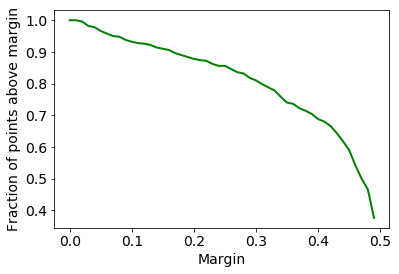

In [474]:
gammas = np.arange(0,0.5,0.01)
f = np.vectorize(lambda g: margin_counts(test_data, final_weights,g))
plt.plot(gammas, f(gammas)/500.0, linewidth=2, color='green')
plt.xlabel('Margin', fontsize=14)
plt.ylabel('Fraction of points above margin', fontsize=14)
plt.show()

Next, we investigate a natural question: Are points `x` with larger margin more likely to be classified correctly?

To address this, we define a function **margin_errors** that computes the fraction of points with margin at least `gamma` that are misclassified.

**Task P7:** Implement the function `margin_errors` that computes the fraction of points with margin at least `gamma` that are misclassified. Copy the code and the output plot (i.e., visualization of the relationship between margin and error rate) to the solution file. What do you observe from the plot?

In [475]:
def margin_errors(feature_matrix, labels, weights, gamma):
## Return error of predictions that lie in intervals [0, 0.5 - gamma) and (0.5 + gamma, 1]

    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # labels: true labels y, a numpy vector of dimension n
    # weights: weight vector to start with, a numpy vector of dimension d+1
    # gamma: the margin value
    # Output:
    # error of predictions that lie in intervals [0, 0.5 - gamma) and (0.5 + gamma, 1]
    
    ## STUDENT: YOUR CODE HERE
    countGamma = 0
    countWrong = 0
    for i in range(feature_matrix.shape[0]):
        x = feature_matrix[i]
        theta = weights
        probPos = 1 / (1 + np.exp(-(1 * (np.dot(theta, x)))))
        probNeg = 1 / (1 + np.exp(-(-1 * (np.dot(theta, x)))))
        
        pred = 0
        if probPos > probNeg:
            pred = 1
        else:
            pred = -1
            
        prob = max(probPos, probNeg)
        
        if ((1 >= prob > gamma + .5) or (0 <= prob < gamma - .5)):
            countGamma += 1
            if pred != labels[i]:
                countWrong += 1    

    return countWrong / countGamma

    ## STUDENT: YOUR CODE ENDS

We now visualize the relationship between margin and error rate.

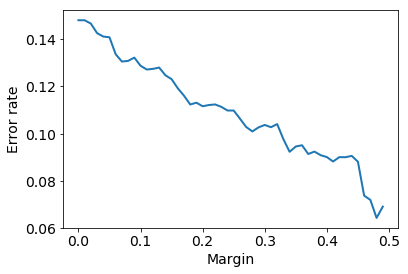

In [476]:
## Create grid of gamma values
gammas = np.arange(0, 0.5, 0.01)

## Compute margin_errors on test data for each value of g
f = np.vectorize(lambda g: margin_errors(test_data, test_labels,final_weights, g))

## Plot the result
plt.plot(gammas, f(gammas), linewidth=2)
plt.ylabel('Error rate', fontsize=14)
plt.xlabel('Margin', fontsize=14)
plt.show()

## 4. Words with large influence

Finally, we attempt to partially **interpret** the logistic regression model.

Which words are most important in deciding whether a sentence is positive? As a first approximation to this, we simply take the words whose coefficients in $\theta$ have the largest positive values.

Likewise, we look at the words whose coefficients in $\theta$ have the most negative values, and we think of these as influential in negative predictions.

**Task P8:** Report the top 10 positive words (i.e., words with the largest positive coefficients of $\theta$) and the top 10 negative words (i.e., words with the most negative coefficients of $\theta$). 

In [469]:
## Convert vocabulary into a list:
## This is a list where the i-th entry corresponds to the 

vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])


## STUDENT: YOUR CODE HERE

# **IGNORE THE INITIAL WEIGHT VALUE
sortIndecies = final_weights.argsort()
posWords = list()
negWords = list()
for i in range(10):
    posWords.append(vocab[sortIndecies[-(i + 1)]])
    negWords.append(vocab[sortIndecies[i]])
    
print('the most positive words are:\t' + str(posWords))
print('the most negative words are:\t' + str(negWords))

## STUDENT: CODE ENDS

the most positive words are:	['scratch', 'perfected', 'function', 'greatest', 'loved', 'awful', 'likes', 'nicest', 'lovely', 'deliciously']
the most negative words are:	['disapppointment', 'poorly', 'wasted', 'sucker', 'arepas', 'disappointment', 'worth', 'dog', 'aversion', 'waste']


## 5. (Bonus question) Classifiers that can abstain

Suppose you are building a classifier, and can tolerate an error rate of at most some value `e`. Unfortunately, every classifier you try has a higher error than this. 

Therefore, you decide that the classifier is allowed to occasionally **abstain**: that is, to say *"don't know"*. When it actually makes a prediction, it must have error rate at most `e`. And subject to this constraint, it should abstain as infrequently as possible.

How would you build an abstaining classifier of this kind, starting from a logistic regression model? To get the bonus score, you need to show the following:

* A general description of the method
* Your code implementation
* A case study to show how you can use it in practice (including necessary plots)

In [479]:
## STUDENT: YOUR CODE HERE


'''
I would fit a fit a linear function that can model the output from P7. Given the degree of confidence that a given email is 
spam or not spam, I could then estimate the error rate. If my error rate would be greater than allowable value, e, I would
respond "don't know" for that particular email.

I do not have time to code this sadly, but hopefully my above explanation is worth partial credit.
'''

## STUDENT: CODE ENDS